# Notes

First iteration is to model: goal to have end to end pipeline from data to dynamics for a patient
- Don't have test train split
- Predict on training data
- Entry is an exercise
- Include exercise meta like https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ 

In [1]:
import os 
import re
import csv
import json
from datetime import datetime

import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Constants

In [2]:
SEQ_MAX_LEN = 600

In [3]:
dir_data_root = os.path.join('..', 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'exercises_raw')
dir_patiens_sessions = os.path.join(dir_data_root, 'json', 'patients_sessions')

# Data prep

### Build training set

In [4]:
def exercise_to_input(file_path):
    with open(file_path, 'r') as f_r:
        exercise = json.load(f_r)
        
        exercise_sequence = []

        for poi in sorted(exercise['pois'].keys()):
            sequences = exercise['pois'][poi]
            exercise_sequence.append(sequences['xs'])
            exercise_sequence.append(sequences['ys'])
            exercise_sequence.append(sequences['zs'])
    
        exercise_sequence = pad_sequences(
            exercise_sequence,
            padding="pre",
            maxlen=SEQ_MAX_LEN)
    
    return exercise['meta']['id'], exercise_sequence, exercise['meta']['evaluation'] - 1

In [5]:
xslist_a = list()
xslist_b = list()
yslist = list()

for file_name in os.listdir(dir_exercises):
    xs_a, xs_b, ys = exercise_to_input(os.path.join(dir_exercises, file_name))
    
    yslist.append(ys)
    xslist_a.append(xs_a)  
    xslist_b.append(xs_b)

depth = len(set(xslist_a))
            
ys = np.array(yslist)
xs_a = tf.one_hot(xslist_a, depth)   
xs_b = np.array(xslist_b) 


print(ys.shape)
print(xs_a.shape)
print(xs_b.shape)

Metal device set to: Apple M1
(1029,)
(1029, 9)
(1029, 63, 600)


2023-03-31 23:57:34.486381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-31 23:57:34.486466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Modeling

In [6]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
inputA = Input(shape=xs_a.shape[1:])
inputB = Input(shape=xs_b.shape[1:])

x_a = Dense(4, activation="relu")(inputA)
x_a = Model(inputs=inputA, outputs=x_a)

x_b = LSTM(64)(inputB)
x_b = Dense(32, activation="relu")(x_b)
x_b = Model(inputs=inputB, outputs=x_b)

combined = concatenate([x_a.output, x_b.output])
x = Dense(16, activation="relu")(combined)
x = Dense(6, activation="relu")(x)
x = Dense(6, activation="softmax")(x)
model = Model(inputs=[x_a.input, x_b.input], outputs=x)

model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=Adam(lr=1e-3, decay=1e-3 / 200),
    metrics=['accuracy']
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 63, 600)]    0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 64)           170240      ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 4)            40          ['input_1[0][0]']                
                                                                                            

/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


In [9]:
weight_training_classes = {0: 0.32075471698113206, 
                           1: 1.1333333333333333,
                           2: 1.3076923076923077, 
                           3: 3.4, 
                           4: 3.4,
                           5: 1.5454545454545454}

In [10]:
model.fit(
    x=[xs_a, xs_b], y=ys, 
    validation_data=([xs_a, xs_b], ys),
    batch_size=8, epochs=20,
    class_weight=weight_training_classes)

Epoch 1/20


2023-03-31 23:57:34.888595: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-31 23:57:35.771416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-31 23:57:35.926164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-31 23:57:36.355356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 1.8657 - accuracy: 0.1526

2023-03-31 23:57:40.296662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-31 23:57:40.359200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 7s 44ms/step - loss: 1.8657 - accuracy: 0.1526 - val_loss: 1.7797 - val_accuracy: 0.3926
Epoch 2/20
129/129 [==============================] - 5s 37ms/step - loss: 1.8479 - accuracy: 0.1895 - val_loss: 1.7988 - val_accuracy: 0.1895
Epoch 3/20
129/129 [==============================] - 5s 36ms/step - loss: 1.8444 - accuracy: 0.1399 - val_loss: 1.8122 - val_accuracy: 0.1720
Epoch 4/20
129/129 [==============================] - 5s 36ms/step - loss: 1.8377 - accuracy: 0.1545 - val_loss: 1.8070 - val_accuracy: 0.1672
Epoch 5/20
129/129 [==============================] - 5s 36ms/step - loss: 1.8215 - accuracy: 0.1808 - val_loss: 1.8077 - val_accuracy: 0.1798
Epoch 6/20
129/129 [==============================] - 5s 36ms/step - loss: 1.8233 - accuracy: 0.1555 - val_loss: 1.7985 - val_accuracy: 0.1759
Epoch 7/20
129/129 [==============================] - 5s 36ms/step - loss: 1.8073 - accuracy: 0.1642 - val_loss: 1.8169 - val_accuracy: 0.1633
Epoch 8/20

In [11]:
from sklearn.metrics import classification_report

y_pred = model.predict([xs_a, xs_b],verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(ys, y_pred_bool))

 1/33 [..............................] - ETA: 11s

2023-03-31 23:59:11.877078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-31 23:59:11.933564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       490
           1       0.20      0.89      0.32       180
           2       0.00      0.00      0.00       135
           3       0.13      0.46      0.20        52
           4       0.00      0.00      0.00        45
           5       0.47      0.12      0.19       127

    accuracy                           0.19      1029
   macro avg       0.13      0.24      0.12      1029
weighted avg       0.10      0.19      0.09      1029



/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

# Patient dynamics

In [12]:
from operator import attrgetter

In [25]:
patient_id = '00000000017'

In [26]:
sessions = []
with open(os.path.join(dir_patiens_sessions, '%s.json' % patient_id), 'r') as f_r:
    sessions = json.load(f_r)
    
print(sessions)

[{'id': 0, 'exercise_dates': '2020-03-05', 'evaluation': 5, 'flag_before_surgery': 0, 'number_of_exercises': 9}, {'id': 1, 'exercise_dates': '2019-12-12', 'evaluation': 5, 'flag_before_surgery': 0, 'number_of_exercises': 9}, {'id': 2, 'exercise_dates': '2019-04-04', 'evaluation': 6, 'flag_before_surgery': 0, 'number_of_exercises': 9}, {'id': 3, 'exercise_dates': '2019-07-11', 'evaluation': 5, 'flag_before_surgery': 0, 'number_of_exercises': 9}]


In [27]:
sessions.sort(key=lambda x: x['exercise_dates'])
print(sessions)

[{'id': 2, 'exercise_dates': '2019-04-04', 'evaluation': 6, 'flag_before_surgery': 0, 'number_of_exercises': 9}, {'id': 3, 'exercise_dates': '2019-07-11', 'evaluation': 5, 'flag_before_surgery': 0, 'number_of_exercises': 9}, {'id': 1, 'exercise_dates': '2019-12-12', 'evaluation': 5, 'flag_before_surgery': 0, 'number_of_exercises': 9}, {'id': 0, 'exercise_dates': '2020-03-05', 'evaluation': 5, 'flag_before_surgery': 0, 'number_of_exercises': 9}]


In [28]:
weights = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0]
exercises_number = 9

In [29]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

6


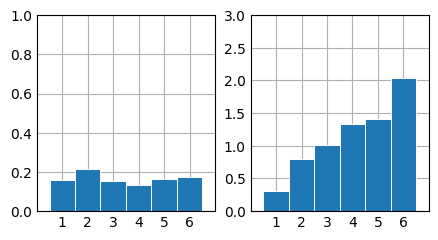

5


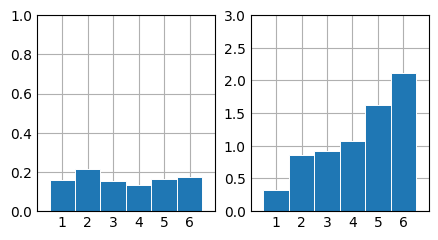

5


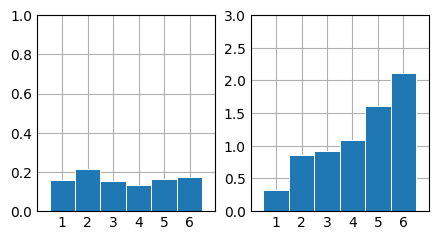

5


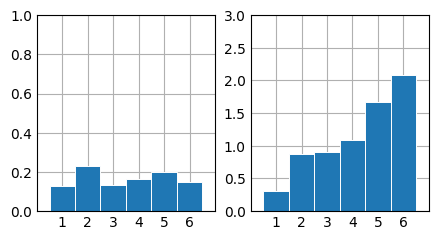

[6.901362210512161, 6.910412013530731, 6.90903040766716, 6.927264630794525]


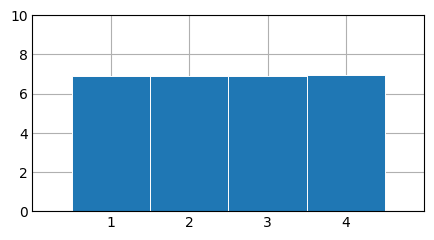

In [30]:
dynamic = []

for session in sessions:
    exercises_result = []
    print(session['evaluation'])
    for exercise_id in range(1, session['number_of_exercises']+1):
        xs_a, xs_b, ys = exercise_to_input(
            os.path.join(
                dir_exercises, '%s_%s_%s.json' % (
                    patient_id, 
                    session['id'],
                    exercise_id
                )))
        
        xs_a = tf.one_hot([xs_a], depth)   
        xs_b = np.array([xs_b]) 
        
        #print(xs_a.shape)
        #print(xs_b.shape)
        
        
        y_pred = model.predict([xs_a, xs_b], verbose=0)
        exercises_result.append(list(y_pred[0]))
    
    #average session 
    prediction = np.average(np.array(exercises_result), axis=0)
    exercise_score = [y*w for y, w in zip(prediction,weights)]
    dynamic.append(sum(exercise_score))
    
    fig, axs = plt.subplots(1,2,figsize=(4,2)) 
        
    x = 1 + np.arange(6)
    y_pred = y_pred[0]
    y_score = exercise_score

    axs[0].bar(x, y_pred, width=1, edgecolor="white", linewidth=0.7)

    axs[0].set(xlim=(0, 7), 
              xticks=np.arange(1, 7),
              ylim=(0, 1), 
             )


    axs[1].bar(x, y_score, width=1, edgecolor="white", linewidth=0.7)
    axs[1].set(xlim=(0, 7), 
              xticks=np.arange(1, 7),
              ylim=(0, 3), 
             )

    plt.show()    
        

print(dynamic)
fig, ax = plt.subplots(figsize=(4,2)) 

x = 1 + np.arange(len(sessions))
y = dynamic

ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

ax.set(xlim=(0, len(sessions) + 1), 
          xticks=np.arange(1, len(sessions) + 1),
          ylim=(0, 10), 
         )

plt.show() 

__END__